In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from scipy import signal
from keras.utils import to_categorical



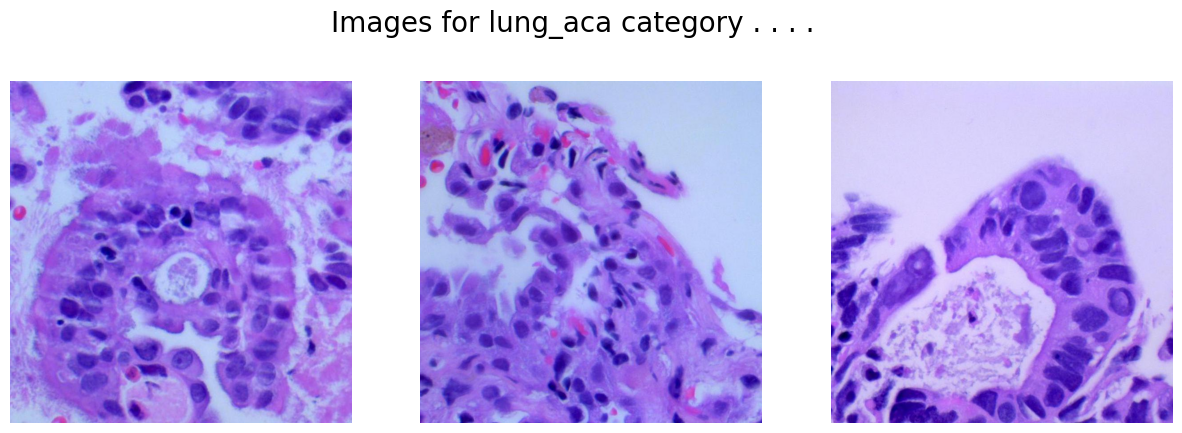

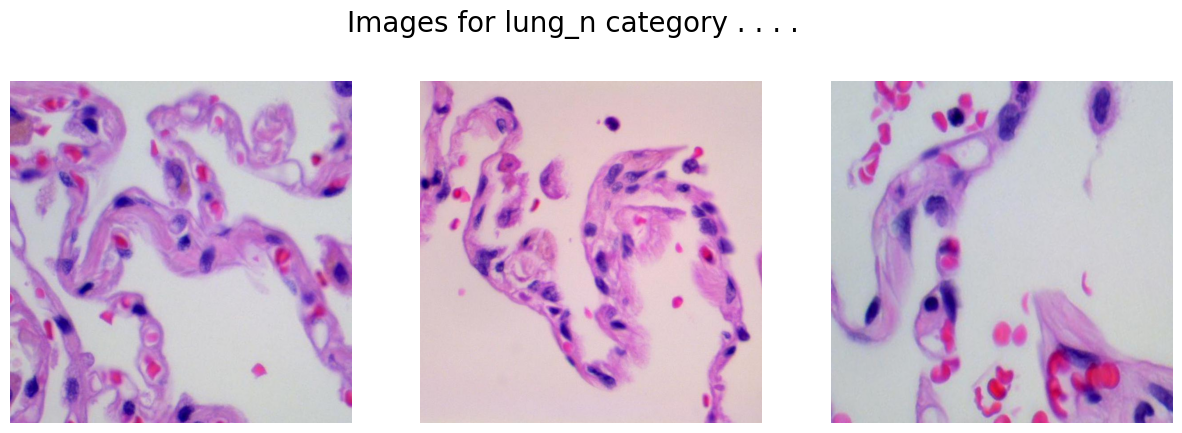

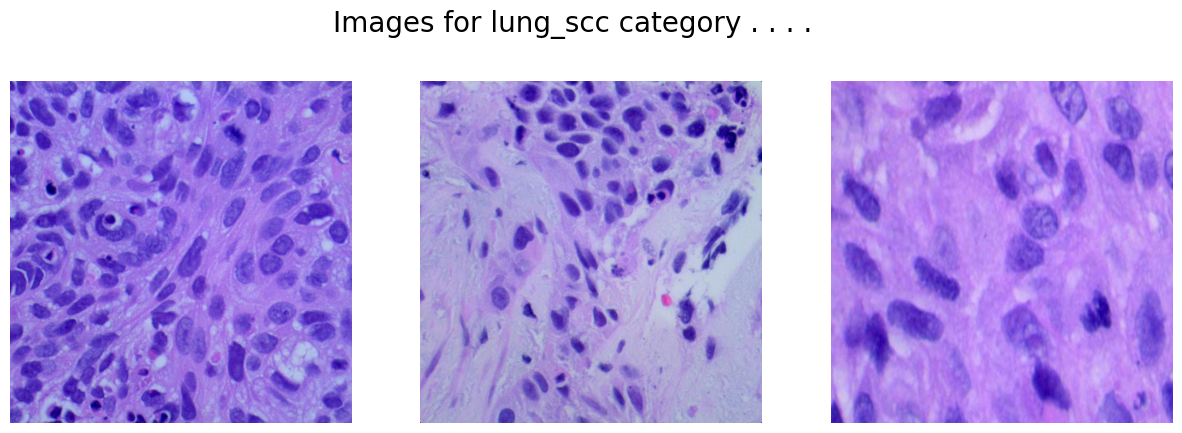

In [2]:
# this dataset is not included in the github because it is too large, however there is a link in the README.txt
path = 'archive (1)/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

# visualization of dataset
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [3]:
IMG_SIZE = 32
SPLIT = 0.2
EPOCHS = 1
BATCH_SIZE = 64

In [4]:
X = []
Y = []

# gets an equal number of each category into the training and testing datasets
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  # only gets 200 of each category into dataset. Can change to "for image in images" and "images[k]" to "image" to get full dataset
  for k in range(200):
    img = cv2.imread(images[k])
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)


In [5]:


# split into test and training sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)


Neural Network Creation

In [6]:
# abstract class for a layer
class Layer: 
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [7]:
# layer that extracts patterns from images using applying filters (kernels) to matrix inputs
# outputs a feature map of pattersn
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    # applies the kernel to the input using Cross-Correlation
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    # calculates and applies the gradients of the kernels and biases
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [8]:
# layer that makes predictions based on features of previous layer using matrix multiplication
# outputs a 1D vector
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    # returns dot product of weights and inputs, plus bias
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    # calculates and applies the gradients of the weights and biases
    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [9]:
# reshapes an input into the specified output shape
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    # returns the reshaped output
    def forward(self, input):
        return np.reshape(input, self.output_shape)

    # reshapes the gradient to the previous input shape
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [10]:
# abstract class for Activations layer
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # applies the activation function
    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    # applies the derivative of the activation function
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

# layer for sigmoid activiation function
class Sigmoid(Activation):
    def __init__(self):
        # defines activation for sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # defines derivative for sigmoid
        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

In [11]:

# all cost functions 

# mean squared error
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

# mean squared error derivative
def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [12]:
# conducts forward propagation given layers of network and input
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

# trains the neural network
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward propagation
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward propagation
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [19]:
# preprocess data with equal amount of image types, spliting into x and y
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    two_index = np.where(y == 2)[0][:limit]
    all_indices = np.hstack((zero_index, one_index, two_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 3, 32, 32)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(len(y), 3, 1)
    return x, y


x_train, y_train = preprocess_data(X_train, Y_train, 100)
x_test, y_test = preprocess_data(X_val, Y_val, 100)

# neural network
network = [
    Convolutional((3, 32, 32), 5, 11),
    Sigmoid(),
    Reshape((11, 28, 28), (11 * 28 * 28, 1)),
    Dense(11 * 28 * 28, 100),
    Sigmoid(),
    Dense(100, 3),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=40,
    learning_rate=0.01
)

# test
right = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    if np.argmax(output) == np.argmax(y):
        right += 1

print("Correct: ", right)
print("Wrong: ", len(y_test) - right)
print("Percentage correct: ", (right / len(y_test)) * 100, "%")


1/40, error=0.7865384319644758
2/40, error=0.6130391568145002
3/40, error=0.5618084148096668
4/40, error=0.5154563718262641
5/40, error=0.49873508021298346
6/40, error=0.4562857370996122
7/40, error=0.449508643000482
8/40, error=0.42022076743677866
9/40, error=0.39375006725445116
10/40, error=0.3913522441414067
11/40, error=0.3777167078375322
12/40, error=0.36440150680958877
13/40, error=0.36470077097969483
14/40, error=0.3500192669324371
15/40, error=0.33759367632061693
16/40, error=0.337711101494322
17/40, error=0.3281838827876123
18/40, error=0.32274982037792194
19/40, error=0.3250048574083385
20/40, error=0.3174754418342996
21/40, error=0.3094541539125189
22/40, error=0.30384253326548166
23/40, error=0.31370112033834
24/40, error=0.3077015661168589
25/40, error=0.2985308239312391
26/40, error=0.2968774241857023
27/40, error=0.3080040384047772
28/40, error=0.29640229577861715
29/40, error=0.2926876865071054
30/40, error=0.28177645651573935
31/40, error=0.285800262641554
32/40, error